In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
from numpy.linalg import inv, norm
from mpl_toolkits import mplot3d
from scipy.stats import multivariate_normal
import seaborn as sns
from sklearn.cluster import KMeans 
from sklearn import neighbors, datasets
import os
import math
import pickle
from sklearn.linear_model import Perceptron
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.svm import SVC
from scipy.special import softmax, expit

from sklearn.metrics import classification_report, confusion_matrix , accuracy_score, log_loss
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

from numpy.random import seed
from tensorflow.random import set_seed

# few global variables
ind = [1,2,3,9]
cmap_bold = [sns.color_palette('bright')[i] for i in ind]
cmap_light = [sns.color_palette('dark')[i] for i in ind]

# Dataset 1B

In [2]:
#reading the training data and storing the features and outputs in corresponding variables
df_train= pd.read_csv("E:\\ubuntu2-windows2\\Sem6\\PRML - CS5691\\Assignments_2021\\Assignment2/Dataset_1B/train.csv",header=None)
df_train.rename(columns={0:"x1", 1:"x2", 2:"y"}, inplace=True)
df_train['y']=df_train['y'].astype('int32')
x_train = np.array(df_train[['x1','x2']]) ; y_train = np.array(df_train[['y']]) ; y_train = y_train.reshape((y_train.shape[0],))

#reading the test data and storing the features and outputs in corresponding variables
df_test= pd.read_csv("E:\\ubuntu2-windows2\\Sem6\\PRML - CS5691\\Assignments_2021\\Assignment2/Dataset_1B/dev.csv",header=None)
df_test.rename(columns={0:"x1", 1:"x2", 2:"y"}, inplace=True)
df_dev = df_test
df_test['y']=df_test['y'].astype('int32')
test_data = np.array(df_test[['x1','x2','y']])
N_dev = test_data.shape[0]
np.random.shuffle(test_data)
x_test = test_data[:N_dev//2, [0,1]]; y_test = test_data[:N_dev//2,2] ; y_test.reshape((y_test.shape[0],))
x1_test = x_test[:,0]; x2_test = x_test[:,1];
val_data = test_data[N_dev//2:,:]
x_va = test_data[N_dev//2:, [0,1]]; y_va = test_data[N_dev//2:,2] ; y_va = y_va.reshape((y_va.shape[0],))
x1_va = x_va[:,0]; x2_va = x_va[:,1];

## MLFFNN

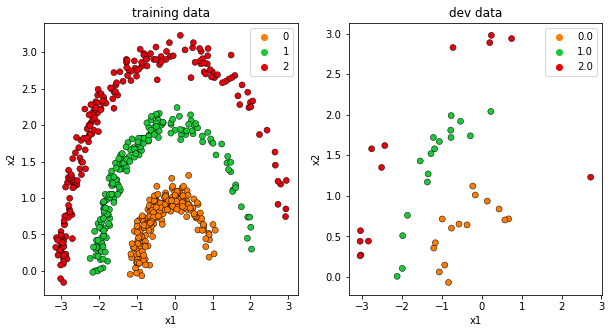

In [137]:
# visualising the data
fig = plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title('training data')
sns.scatterplot(x=x_train[:,0],y=x_train[:,1],hue=y_train.reshape((y_train.shape[0])),palette=cmap_bold[:3],alpha=1.0,edgecolor='black')
plt.xlabel('x1') ; plt.ylabel('x2')
plt.subplot(1,2,2)
plt.title('dev data')
sns.scatterplot(x=x_test[:,0],y=x_test[:,1],hue=y_test.reshape((y_test.shape[0])),palette=cmap_bold[:3],alpha=1.0,edgecolor='black')
plt.xlabel('x1') ; plt.ylabel('x2')
plt.show()

In [99]:
# utilities
def build_mlfnn(hidden_neurons,num_layers=1,num_classes=4): #hidden neurons is a list of number of hidden units in each hidden layer
    model=tf.keras.models.Sequential()
    model.add(tf.keras.Input(shape=(2)))
    model.add(tf.keras.layers.Dense(hidden_neurons[0],activation='sigmoid'))
    if num_layers==2:
        model.add(tf.keras.layers.Dense(hidden_neurons[1],activation='sigmoid'))

    model.add(tf.keras.layers.Dense(num_classes,activation='softmax'))
    return model

def train_model(model,epochs,X_train,Y_train,X_valid,Y_valid,verbose = 0):
    model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,optimizer=keras.optimizers.SGD(lr=1),metrics=['accuracy'])
    history=model.fit(X_train,Y_train,epochs=epochs,batch_size=32,validation_data=(X_valid,Y_valid),verbose=verbose)
    return history

def plot_nn_decision_regions (x_train,y_train,model,palette_bold,palette_light):
    # sns.scatterplot(x=x_train[:,0],y=x_train[:,1],hue=y_train,palette=palette_bold,alpha=1.0,edgecolor="black",legend=False)

    xlim =  [np.amin(x_train[:,0]),np.amax(x_train[:,0])]
    ylim = [np.amin(x_train[:,1]),np.amax(x_train[:,1])]

    # create grid to evaluate model
    xx = np.linspace(xlim[0], xlim[1], 300)
    yy = np.linspace(ylim[0], ylim[1], 300)
    plt.xlim(xlim) ; plt.ylim(ylim)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.c_[XX.ravel(), YY.ravel()]
    # print(xx.shape ,xy.shape,sep = '\n')
    Z = np.argmax(model.predict(xy),axis=1)
    n = np.unique(Z).shape[0]
    # plot decision boundary and margins
    sns.scatterplot(x = XX.ravel(),y = YY.ravel(), hue = Z.ravel(),palette=palette_light[:n],legend= True)
    sns.scatterplot(x=x_train[:,0],y=x_train[:,1],hue=y_train,palette=palette_bold,alpha=1.0,edgecolor="black",legend=False)


In [5]:
# tables of classification accuracies for different values of hyperparameters
epochs = 30
seed(0)
set_seed(0)
list_h_neurons = [[2,2],[3,3],[4,4],[5,5],[6,6],[7,7],[8,8],[9,9],[10,10],[6],[7],[8],[9],[10],[11],[12],[13],[14],[15],[16],[17],[18]]
accs_and_loss = [] # store tuples of (h_neurons,tr_acc,tr_loss,va_acc,va_loss)
for h_neurons in list_h_neurons:
    model = build_mlfnn(hidden_neurons=h_neurons,num_layers=len(h_neurons),num_classes=3)
    train_model(model,epochs,x_train,y_train,x_va,y_va)
    print('\n *************************************************** \n')
    yhat_tr = model.predict(x_train) ; yhat_tr = np.argmax(yhat_tr,axis=1)
    yhat_va = model.predict(x_va)    ; yhat_va = np.argmax(yhat_va,axis=1)
#     yhat_te = model.predict(x_test)    ; yhat_te = np.argmax(yhat_te,axis=1) 
    
    tr_loss,tr_acc  = model.evaluate(x_train,y_train)
    va_loss,va_acc  = model.evaluate(x_va,y_va)
    accs_and_loss.append((h_neurons,round(tr_acc,3),round(tr_loss,3),round(va_acc,3),round(va_loss,3)))

print('hidden layers , training accuracy, training loss , validation accuracy, validation loss:')
for i in range(len(list_h_neurons)):
    print(accs_and_loss[i]) 


 *************************************************** 

2/2 [==============================] - 0s 0s/step - loss: 0.1075 - accuracy: 1.0000

 *************************************************** 

2/2 [==============================] - 0s 0s/step - loss: 0.1158 - accuracy: 1.0000

 *************************************************** 

2/2 [==============================] - 0s 0s/step - loss: 0.0390 - accuracy: 1.0000

 *************************************************** 

2/2 [==============================] - 0s 0s/step - loss: 0.0473 - accuracy: 1.0000

 *************************************************** 

2/2 [==============================] - 0s 0s/step - loss: 0.0412 - accuracy: 1.0000

 *************************************************** 

2/2 [==============================] - 0s 0s/step - loss: 0.3181 - accuracy: 0.8667

 *************************************************** 

2/2 [==============================] - 0s 0s/step - loss: 0.0760 - accuracy: 1.0000

 ******************

clearly, all the single hidden layer models have high validation loss than double hidden layer model with 5 hidden layers each.  
And also this model is less complex than other high validation accuracy and low validation loss models with single hidden layer.  
So, we choose this as the best model.

In [6]:
# classification accuracy of best model on test data
seed(0)
set_seed(0)
epochs = 30
model = build_mlfnn(hidden_neurons=[5,5],num_layers=2,num_classes=3)
train_model(model,epochs,x_train,y_train,x_va,y_va)

te_loss,te_acc = model.evaluate(x_test,y_test)
print(round(te_loss,3),te_acc*100)

2/2 [==============================] - 0s 0s/step - loss: 0.0374 - accuracy: 1.0000
0.037 100.0


2/2 [==============================] - 0s 0s/step - loss: 0.0402 - accuracy: 1.0000


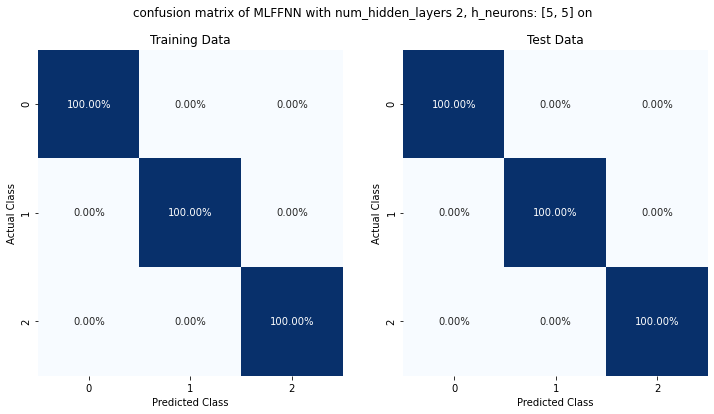

In [27]:
#confusion matrix for best model on Training and Test Data
seed(0)
set_seed(0)
h_neurons = [5,5]
epochs = 30
model = build_mlfnn(hidden_neurons=h_neurons,num_layers=len(h_neurons),num_classes=3)
train_model(model,epochs,x_train,y_train,x_va,y_va)

yhat_tr = model.predict(x_train) ; yhat_tr = np.argmax(yhat_tr,axis=1)
yhat_te = model.predict(x_test)  ; yhat_te = np.argmax(yhat_te,axis=1)
model.evaluate(x_train,y_train) ; model.evaluate(x_va,y_va)

fig = plt.figure(figsize=(12,6))
plt.suptitle(f'confusion matrix of MLFFNN with num_hidden_layers {len(h_neurons)}, h_neurons: {h_neurons} on')
for i in range(2):
    plt.subplot(1,2,i+1)
    cf = confusion_matrix(y_train,yhat_tr,normalize='true')if i==0 else confusion_matrix(y_test,yhat_te,normalize='true')
    sns.heatmap(cf,annot=True,fmt='.2%',cmap='Blues',cbar=False)
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')
    plt.title('Training Data' if i==0 else 'Test Data') 
plt.show()


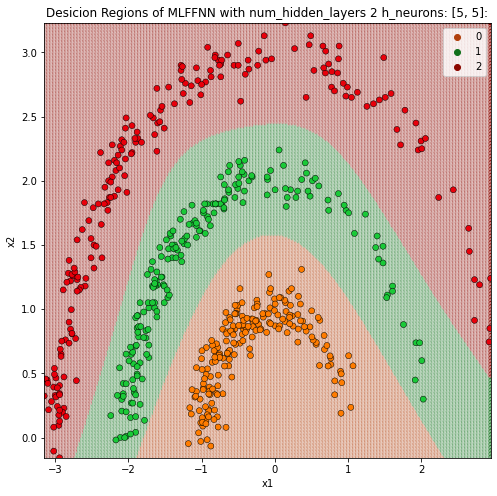

In [13]:
#plot of decision regions using the same model from above cell
fig = plt.figure(figsize=(8,8))
plt.title(f'Desicion Regions of MLFFNN with num_hidden_layers {len(h_neurons)} h_neurons: {h_neurons}:')
plt.xlabel('x1') ; plt.ylabel('x2')
palette_bold = cmap_bold[:3] ; palette_light = cmap_light[:3]
plot_nn_decision_regions (x_train,y_train,model,palette_bold,palette_light)
plt.show()

In [111]:
# utilities
def build_mlfnn(hidden_neurons,num_layers=1,num_classes=4): #hidden neurons is a list of number of hidden units in each hidden layer
    model=tf.keras.models.Sequential()
    model.add(tf.keras.Input(shape=(2)))
    model.add(tf.keras.layers.Dense(hidden_neurons[0],activation='sigmoid'))
    if num_layers==2:
        model.add(tf.keras.layers.Dense(hidden_neurons[1],activation='sigmoid'))

    model.add(tf.keras.layers.Dense(num_classes,activation='softmax'))
    return model

def train_model(model,epochs,X_train,Y_train,X_valid,Y_valid,verbose = 0):
    model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,optimizer=keras.optimizers.SGD(lr=1),metrics=['accuracy'])
    history=model.fit(X_train,Y_train,epochs=epochs,batch_size=32,validation_data=(X_valid,Y_valid),verbose=verbose,callbacks=[early_stopping])
    return history

def plot_nn_decision_regions (x_train,y_train,model,palette_bold,palette_light):
    # sns.scatterplot(x=x_train[:,0],y=x_train[:,1],hue=y_train,palette=palette_bold,alpha=1.0,edgecolor="black",legend=False)

    xlim =  [np.amin(x_train[:,0]),np.amax(x_train[:,0])]
    ylim = [np.amin(x_train[:,1]),np.amax(x_train[:,1])]

    # create grid to evaluate model
    xx = np.linspace(xlim[0], xlim[1], 300)
    yy = np.linspace(ylim[0], ylim[1], 300)
    plt.xlim(xlim) ; plt.ylim(ylim)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.c_[XX.ravel(), YY.ravel()]
    # print(xx.shape ,xy.shape,sep = '\n')
    Z = np.argmax(model.predict(xy),axis=1)
    n = np.unique(Z).shape[0]
    # plot decision boundary and margins
    sns.scatterplot(x = XX.ravel(),y = YY.ravel(), hue = Z.ravel(),palette=palette_light[:n],legend= True)
    sns.scatterplot(x=x_train[:,0],y=x_train[:,1],hue=y_train,palette=palette_bold,alpha=1.0,edgecolor="black",legend=False)


early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    min_delta = 0.0001,
    verbose=1,
    patience=10,
    mode='min',
    restore_best_weights=True)


In [124]:
epochs_ = [1,5,20,100,250]
seed(0)
set_seed(0)
h_neurons = [5,5]
hidden_1 = [] # will contain 5x5 (no_hidden_nodes x no_epochs_considered) numpy arrays 
hidden_2 = [] # will contain 5x5 (no_hidden_nodes x no_epochs_considered) nummpy arrays
output = [] # will contain 3x5 (no_output_nodes x no_epochs_considered)numpy arrays
for epochs in epochs_ :
    model = build_mlfnn(hidden_neurons=h_neurons,num_layers=len(h_neurons),num_classes=3)
    train_model(model,epochs,x_train,y_train,x_va,y_va,verbose=0)
    
    xlim =  [np.amin(x_train[:,0]),np.amax(x_train[:,0])]
    ylim = [np.amin(x_train[:,1]),np.amax(x_train[:,1])]

    # create grid to evaluate model
    xx = np.linspace(xlim[0], xlim[1], 300)
    yy = np.linspace(ylim[0], ylim[1], 300)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.c_[XX.ravel(), YY.ravel()]
    
    weights = [] # contains the weights and biases of different layers sequentially
    for i in range(6):
        weights.append(model.weights[i].numpy())
    
    h_1 = expit(np.matmul(xy,weights[0]) + weights[1])
    hidden_1.append(h_1)
    h_2 = expit(np.matmul(h_1,weights[2]) + weights[3])
    hidden_2.append(h_2)
    out = softmax(np.matmul(h_2,weights[4]) + weights[5])
    output.append(out)

Restoring model weights from the end of the best epoch.
Epoch 00242: early stopping


The evolution of outputs of 1st hidden layer:


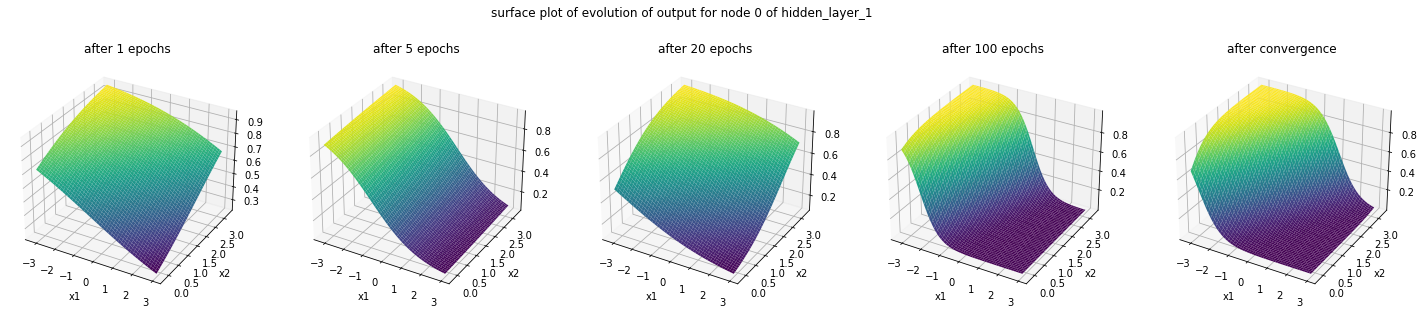

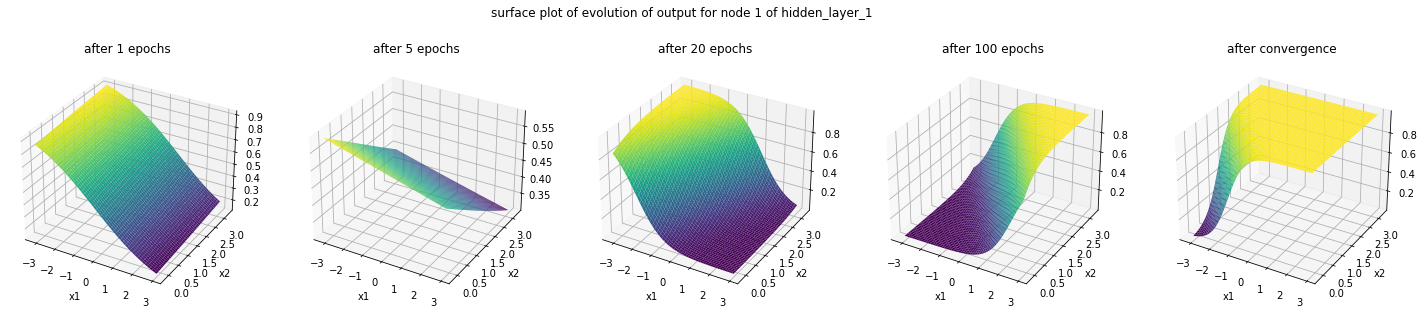

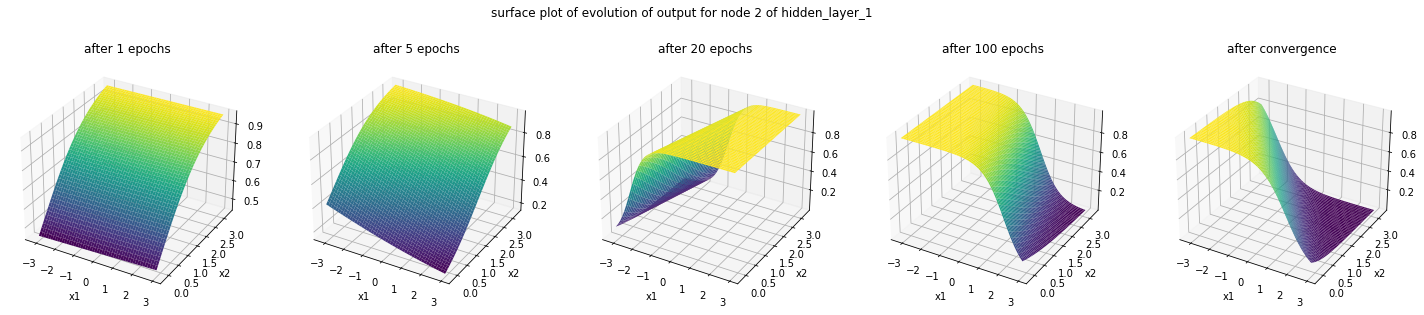

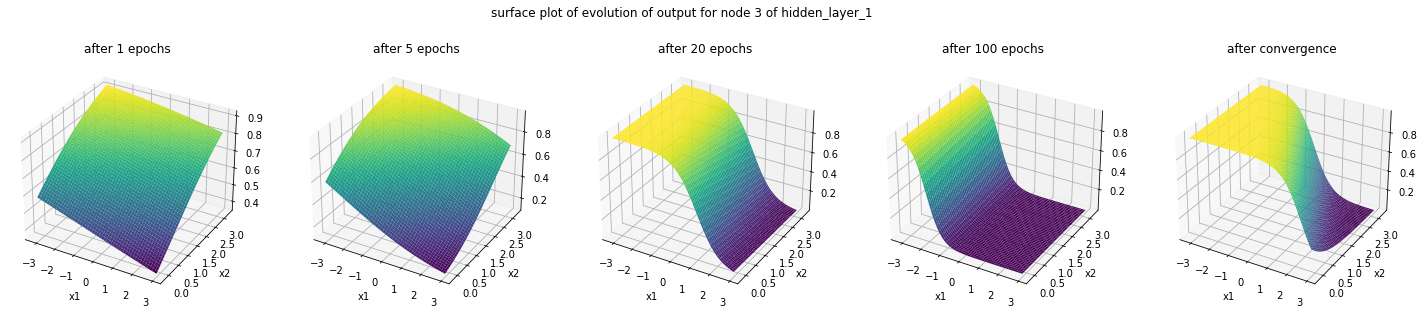

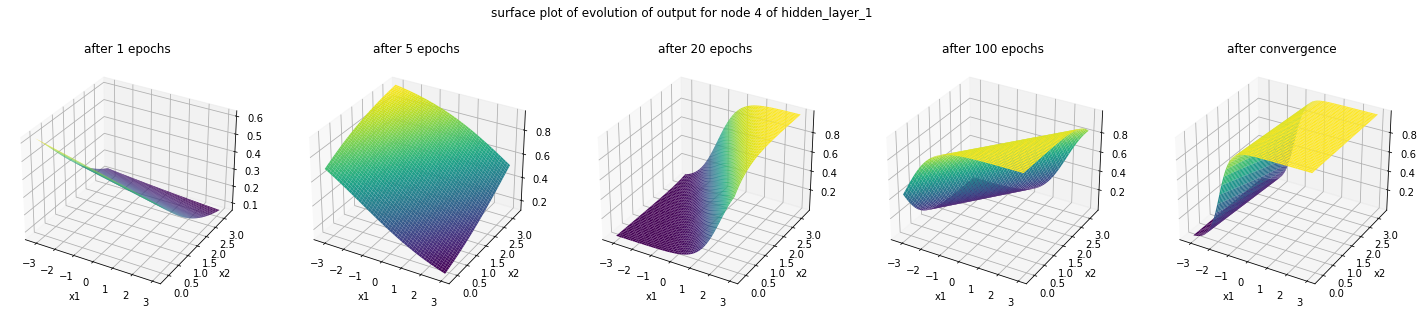

*******************************************


The evolution of outputs of 2nd hidden layer:


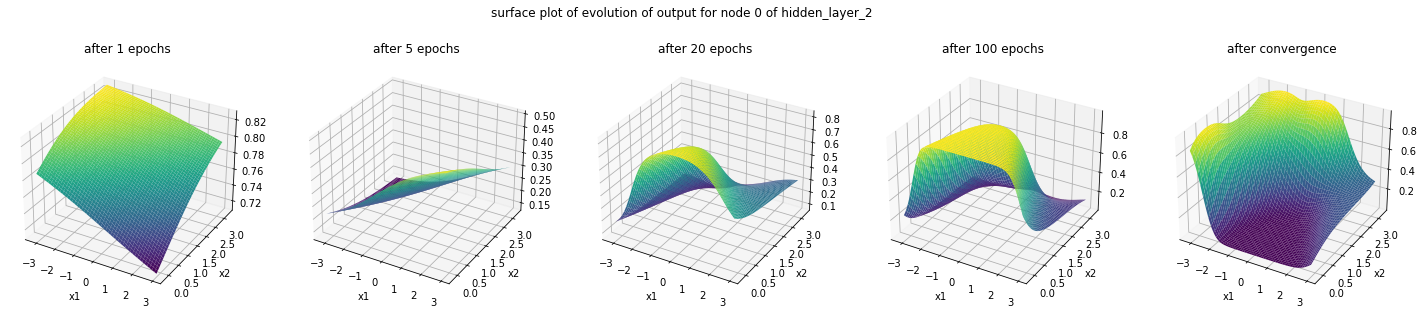

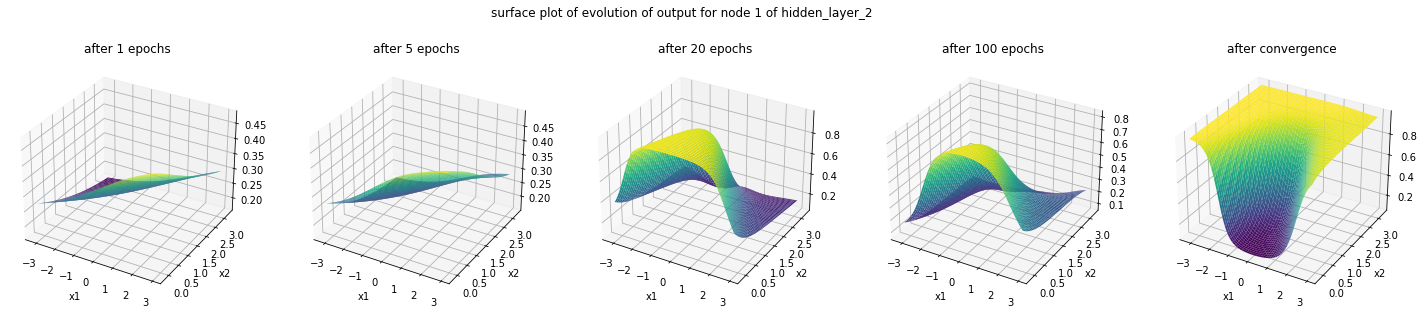

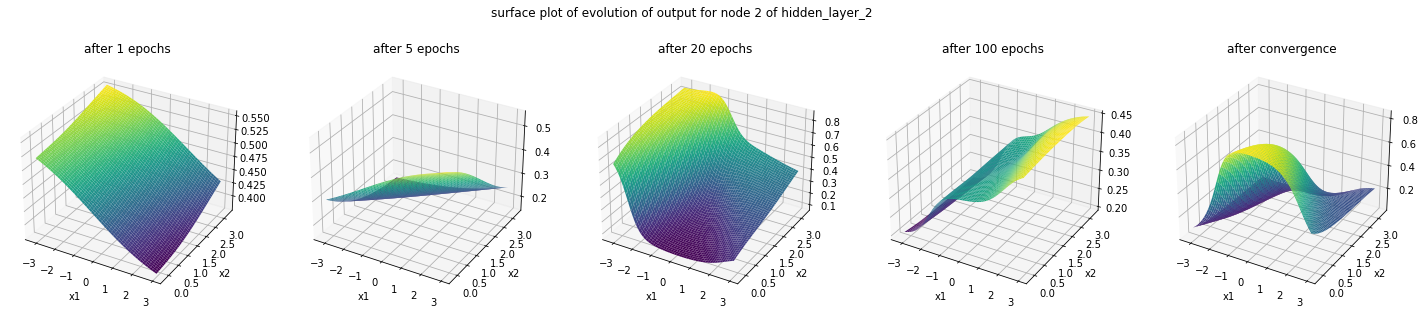

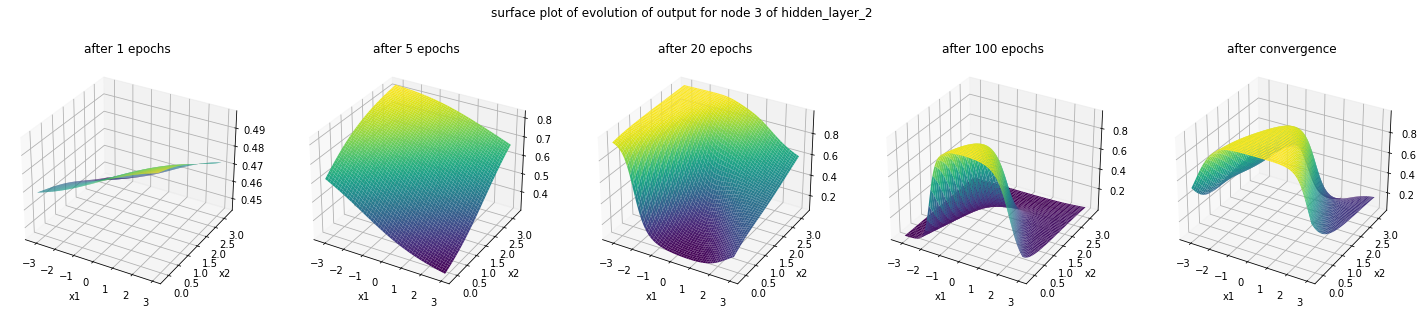

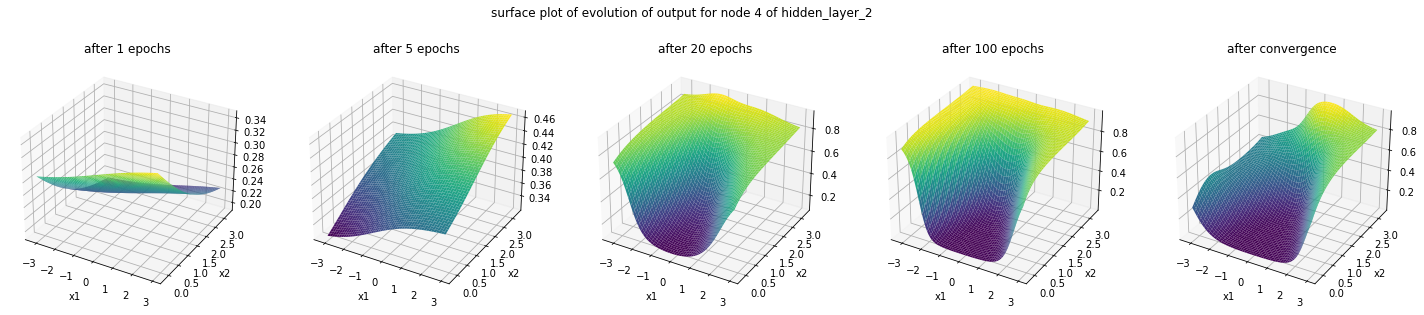

*******************************************


The evolution of outputs of output layer:


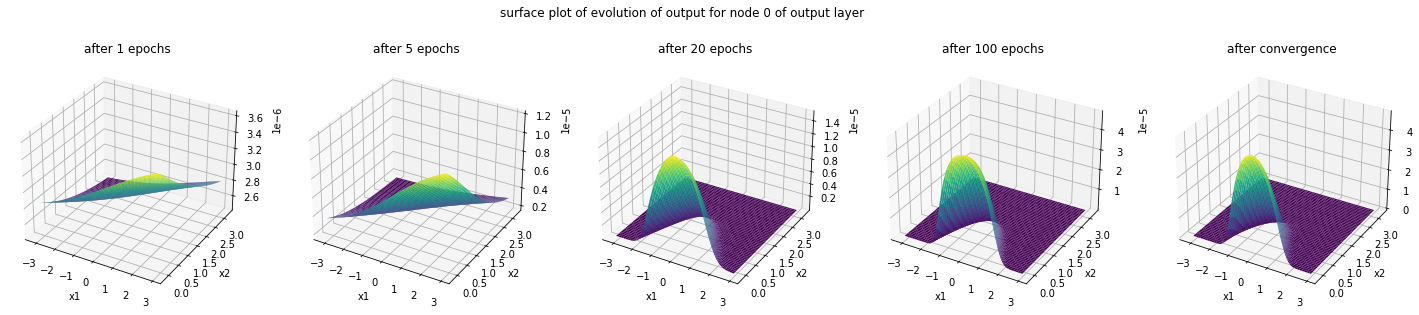

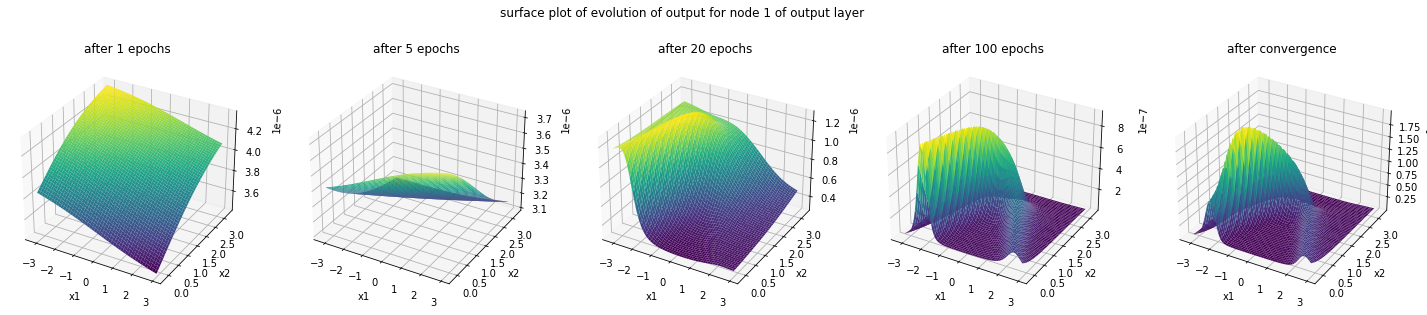

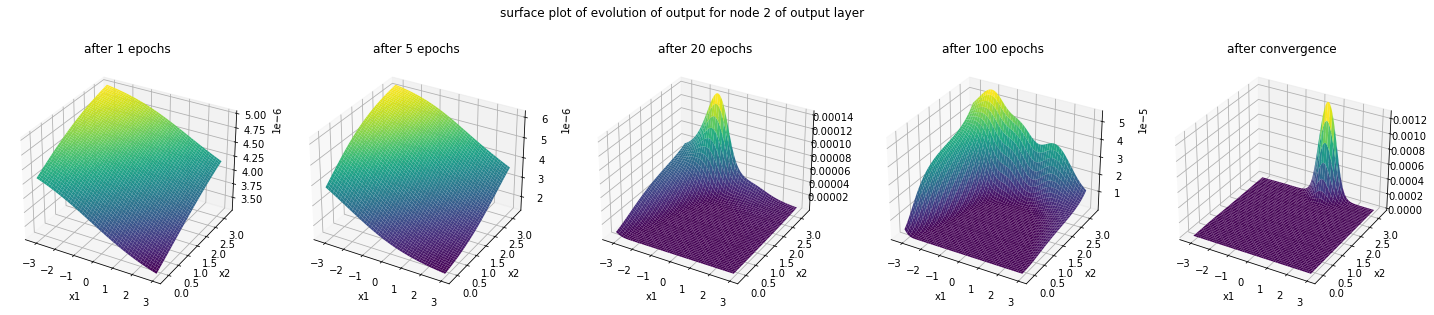

In [136]:
# plotting the evolution of outputs of nodes
print('The evolution of outputs of 1st hidden layer:')
num = hidden_1[0].shape[1]
for i in range(num):
    fig = plt.figure(figsize=(25,5))
    plt.suptitle(f'surface plot of evolution of output for node {i} of hidden_layer_1')
    ax = {}
    for j in range(len(hidden_1)):
#         plt.subplot(1,5,j+1)
#         ax = plt.axes(projection='3d')
        plot_no = 150 + j+1
        ax[j] = fig.add_subplot(plot_no, projection='3d')
        ax[j].plot_surface(XX, YY, hidden_1[j][:,i].reshape(XX.shape),cmap='viridis', edgecolor='none')
        if j != (len(hidden_1)-1):
            ax[j].set_title(f'after {epochs_[j]} epochs')
        else :
            ax[j].set_title('after convergence')
        plt.xlabel('x1')
        plt.ylabel('x2')
    plt.show()
print("*******************************************\n\n")
print('The evolution of outputs of 2nd hidden layer:')
num = hidden_2[0].shape[1]
for i in range(num):
    fig = plt.figure(figsize=(25,5))
    plt.suptitle(f'surface plot of evolution of output for node {i} of hidden_layer_2')
    ax = {}
    for j in range(len(hidden_2)):
#         plt.subplot(1,5,j+1)
#         ax = plt.axes(projection='3d')
        plot_no = 150 + j+1
        ax[j] = fig.add_subplot(plot_no, projection='3d')
        ax[j].plot_surface(XX, YY, hidden_2[j][:,i].reshape(XX.shape),cmap='viridis', edgecolor='none')
        if j != (len(hidden_1)-1):
            ax[j].set_title(f'after {epochs_[j]} epochs')
        else :
            ax[j].set_title('after convergence')
        plt.xlabel('x1')
        plt.ylabel('x2')
    plt.show()
print("*******************************************\n\n")
print('The evolution of outputs of output layer:')
num = output[0].shape[1]
for i in range(num):
    fig = plt.figure(figsize=(25,5))
    plt.suptitle(f'surface plot of evolution of output for node {i} of output layer')
    ax = {}
    for j in range(len(output)):
#         plt.subplot(1,5,j+1)
#         ax = plt.axes(projection='3d')
        plot_no = 150 + j+1
        ax[j] = fig.add_subplot(plot_no, projection='3d')
        ax[j].plot_surface(XX, YY, output[j][:,i].reshape(XX.shape),cmap='viridis', edgecolor='none')
        if j != (len(output)-1):
            ax[j].set_title(f'after {epochs_[j]} epochs')
        else :
            ax[j].set_title('after convergence')
        plt.xlabel('x1')
        plt.ylabel('x2')
    plt.show()

## Non-Linear SVM

In [64]:
# checking the hyperparameter - degree
classes = [0,1,2]
degrees = [1,2,3,4,5,6,7,8,9] ; c = 1000
accs = [] # store tuples of (h_neurons,tr_acc,tr_loss,va_acc,va_loss)
for degree in degrees:
    #creating a ovr classifier
    print(degree,end=' ')
    classifier = SVC(kernel = 'poly' , degree = degree , C = c) 
    non_linear_ovr = OneVsRestClassifier(classifier)
    non_linear_ovr.fit(x_train,y_train)

    yhat_va = non_linear_ovr.predict(x_va)
    yhat_tr = non_linear_ovr.predict(x_train)
    
    tr_acc  = accuracy_score(y_train,yhat_tr)
    va_acc  = accuracy_score(y_va,yhat_va)
    accs.append((degree,round(tr_acc,3),round(va_acc,3)))

print('degree, training accuracy, validation accuracy:')
for i in range(len(degrees)):
    print(accs[i]) 

1 2 3 4 5 6 7 8 9 degree, training accuracy, validation accuracy:
(1, 0.632, 0.667)
(2, 0.997, 0.978)
(3, 0.97, 0.956)
(4, 0.992, 0.956)
(5, 0.993, 0.978)
(6, 0.988, 0.956)
(7, 0.988, 0.956)
(8, 0.993, 0.956)
(9, 0.99, 0.956)


In [59]:
# checking the hyperparameter - c
classes = [0,1,2]
cs= [1e-4,1e-3,1e-2,1e-1,1,1e1,1e2,1e3] ; degree = 2
accs = [] # store tuples of (h_neurons,tr_acc,tr_loss,va_acc,va_loss)
for c in cs:
    #creating a ovr classifier
    print(c,end=' ')
    classifier = SVC(kernel = 'poly' , degree = degree , C = c) 
    non_linear_ovr = OneVsRestClassifier(classifier)
    non_linear_ovr.fit(x_train,y_train)

    yhat_va = non_linear_ovr.predict(x_va)
    yhat_tr = non_linear_ovr.predict(x_train)
    
    tr_acc  = accuracy_score(y_train,yhat_tr)
    va_acc  = accuracy_score(y_va,yhat_va)
    accs.append((c,round(tr_acc,3),round(va_acc,3)))

print('C, training accuracy, validation accuracy:')
for i in range(len(cs)):
    print(accs[i]) 

0.0001 0.001 0.01 0.1 1 10.0 100.0 1000.0 C, training accuracy, validation accuracy:
(0.0001, 0.667, 0.667)
(0.001, 0.667, 0.667)
(0.01, 0.667, 0.667)
(0.1, 0.75, 0.733)
(1, 0.955, 0.956)
(10.0, 0.992, 0.956)
(100.0, 0.997, 0.978)
(1000.0, 0.997, 0.978)


From the above two cells, we see that good value of c is 100 and degree is 2

In [69]:
# classfication accuracy of best model on test data
degree , c = 2 , 100
classifier = SVC(kernel = 'poly' , degree = degree , C = c) 
non_linear_ovr = OneVsRestClassifier(classifier)
non_linear_ovr.fit(x_train,y_train)

yhat_te= non_linear_ovr.predict(x_test)
acc_te = accuracy_score(y_test,yhat_te)
print(f'Test data accuracy of best model is {acc_te*100}%')

Test data accuracy of best model is 100.0%


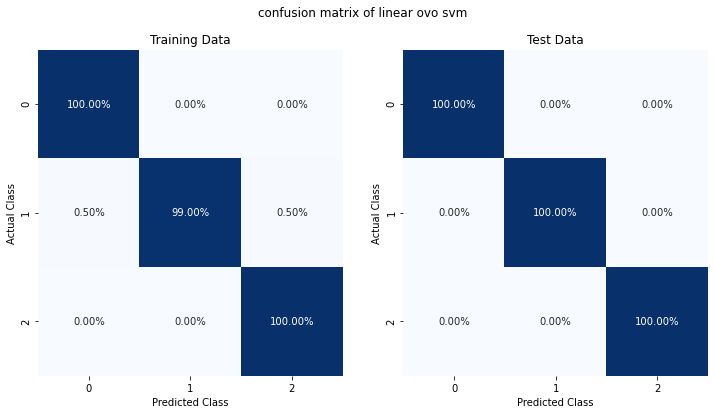

In [62]:
# confusion matrix for best model on training and test data
degree , c = 2 , 100
classifier = SVC(kernel = 'poly' , degree = degree , C = c) 
non_linear_ovr = OneVsRestClassifier(classifier)
non_linear_ovr.fit(x_train,y_train)

yhat_te= non_linear_ovr.predict(x_test)
yhat_tr = non_linear_ovr.predict(x_train)

fig = plt.figure(figsize=(12,6))
plt.suptitle(f'confusion matrix of non-linear svm with ovr approach on :')
for i in range(2):
    plt.subplot(1,2,i+1)
    cf = confusion_matrix(y_train,yhat_tr,normalize='true') if i==0 else confusion_matrix(y_test,yhat_te,normalize='true')
    sns.heatmap(cf,annot=True,fmt='.2%',cmap='Blues',cbar=False)
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')
    plt.title('Training Data' if i==0 else 'Test Data') 
plt.show()

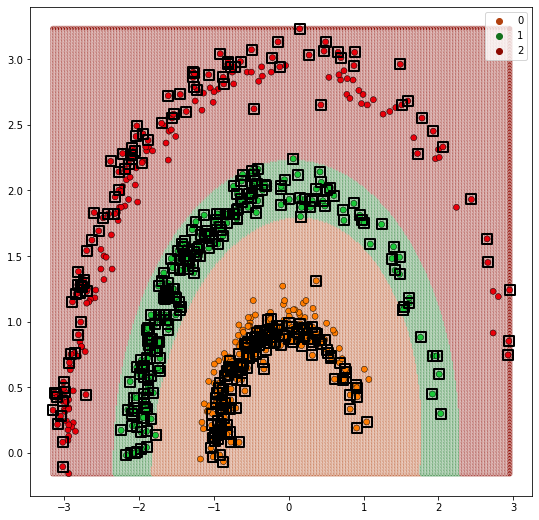

In [63]:
# plot of decision regions and support vectors
palette_light = cmap_light[:3]
palette_bold = cmap_bold[:3]

fig = plt.figure(figsize=(9,9))
ax = plt.gca()
xlim =  [np.amin(x_train[:,0]),np.amax(x_train[:,0])]
ylim = [np.amin(x_train[:,1]),np.amax(x_train[:,1])]
# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 300)
yy = np.linspace(ylim[0], ylim[1], 300)
YY, XX = np.meshgrid(yy, xx)
xy = np.c_[XX.ravel(), YY.ravel()]
Z = non_linear_ovr.predict(xy)
n = np.unique(Z).shape[0]
sns.scatterplot(x = XX.ravel(),y = YY.ravel(), hue = Z,palette=palette_light[:n],legend= True)
sns.scatterplot(x=x_train[:,0],y=x_train[:,1],hue=y_train.reshape((y_train.shape[0],)),palette=palette_bold,
                alpha=1.0,edgecolor="black",legend=False)
markers = ['^','v','>','<','*','+']
# for i in range(len(classes)):
#     plt.scatter(non_linear_ovr.estimators_[i].support_vectors_[:, 0], non_linear_ovr.estimators_[i].support_vectors_[:, 1]
#               ,marker=markers[i],color='k',linewidth=2,label=f'support vectors of class{classes[i]}')
for i in range(len(classes)):
    plt.scatter(non_linear_ovr.estimators_[i].support_vectors_[:, 0], non_linear_ovr.estimators_[i].support_vectors_[:, 1]
              ,marker='s',color='k',s=100,facecolors='none',linewidth=2)
plt.legend()
plt.show()

## Gaussian SVM

In [67]:
# checking the hyperparameter - gamma
classes = [0,1,2]
gammas = [1e-4,1e-3,1e-2,1e-1,1,1e1] ; c = 100
accs = [] # store tuples of (h_neurons,tr_acc,tr_loss,va_acc,va_loss)
for gamma in gammas:
    #creating a ovr classifier
    print(gamma,end=' ')
    classifier = SVC(kernel = 'rbf', gamma=gamma, C = c) 
    gaussian_ovr = OneVsRestClassifier(classifier)
    gaussian_ovr.fit(x_train,y_train)

    yhat_va = gaussian_ovr.predict(x_va)
    yhat_tr = gaussian_ovr.predict(x_train)
    
    tr_acc  = accuracy_score(y_train,yhat_tr)
    va_acc  = accuracy_score(y_va,yhat_va)
    accs.append((gamma,round(tr_acc,3),round(va_acc,3)))

print('gamma, training accuracy, validation accuracy:')
for i in range(len(gammas)):
    print(accs[i]) 

0.0001 0.001 0.01 0.1 1 10.0 gamma, training accuracy, validation accuracy:
(0.0001, 0.623, 0.644)
(0.001, 0.648, 0.644)
(0.01, 0.967, 1.0)
(0.1, 1.0, 1.0)
(1, 1.0, 1.0)
(10.0, 1.0, 1.0)


In [68]:
# checking the hyperparameter - c
classes = [0,1,2]
cs= [1e-4,1e-3,1e-2,1e-1,1,1e1,1e2,1e3] ; gammma = 1
accs = [] # store tuples of (h_neurons,tr_acc,tr_loss,va_acc,va_loss)
for c in cs:
    #creating a ovr classifier
    print(c,end=' ')
    classifier = SVC(kernel = 'rbf', gamma=gamma, C = c) 
    gaussian_ovr = OneVsRestClassifier(classifier)
    gaussian_ovr.fit(x_train,y_train)

    yhat_va = gaussian_ovr.predict(x_va)
    yhat_tr = gaussian_ovr.predict(x_train)
    
    tr_acc  = accuracy_score(y_train,yhat_tr)
    va_acc  = accuracy_score(y_va,yhat_va)
    accs.append((c,round(tr_acc,3),round(va_acc,3)))

print('C, training accuracy, validation accuracy:')
for i in range(len(cs)):
    print(accs[i]) 

0.0001 0.001 0.01 0.1 1 10.0 100.0 1000.0 C, training accuracy, validation accuracy:
(0.0001, 1.0, 1.0)
(0.001, 1.0, 1.0)
(0.01, 1.0, 1.0)
(0.1, 1.0, 1.0)
(1, 1.0, 1.0)
(10.0, 1.0, 1.0)
(100.0, 1.0, 1.0)
(1000.0, 1.0, 1.0)


From the outputs of above two cells we see that optimal value of gamma is 0.1 and c is 100 (for no outliers)

In [72]:
# classfication accuracy of best model on test data
gamma , c = 0.1 , 100
classifier = SVC(kernel = 'rbf' , gamma = gamma , C = c) 
gaussian_ovr = OneVsRestClassifier(classifier)
gaussian_ovr.fit(x_train,y_train)

yhat_te= gaussian_ovr.predict(x_test)
acc_te = accuracy_score(y_test,yhat_te)
print(f'Test data accuracy of best model is {acc_te*100}%')

Test data accuracy of best model is 100.0%


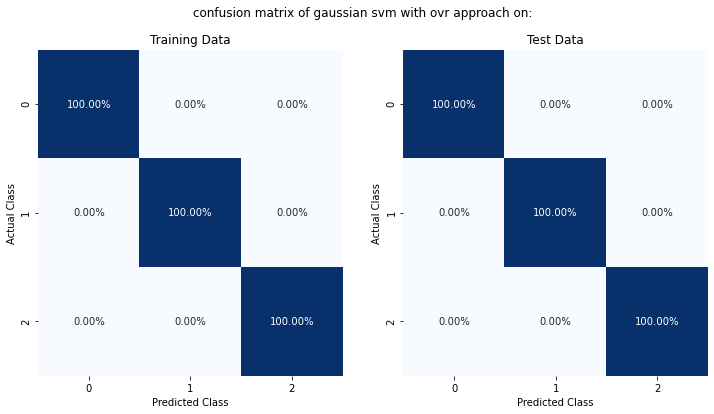

In [73]:
# confusion matrix for best model on training and test data
gamma , c = 0.1 , 100
classifier = SVC(kernel = 'rbf' , gamma = gamma , C = c) 
gaussian_ovr = OneVsRestClassifier(classifier)
gaussian_ovr.fit(x_train,y_train)

yhat_te= gaussian_ovr.predict(x_test)
yhat_tr = gaussian_ovr.predict(x_train)

fig = plt.figure(figsize=(12,6))
plt.suptitle(f'confusion matrix of gaussian svm with ovr approach on:')
for i in range(2):
    plt.subplot(1,2,i+1)
    cf = confusion_matrix(y_train,yhat_tr,normalize='true') if i==0 else confusion_matrix(y_test,yhat_te,normalize='true')
    sns.heatmap(cf,annot=True,fmt='.2%',cmap='Blues',cbar=False)
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')
    plt.title('Training Data' if i==0 else 'Test Data') 
plt.show()

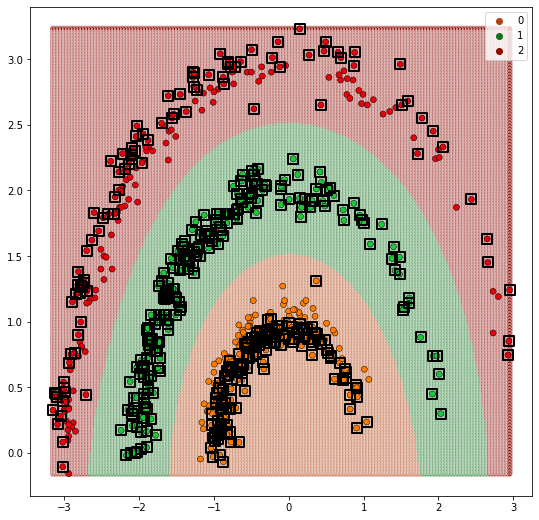

In [74]:
# plot of decision regions and support vectors
palette_light = cmap_light[:3]
palette_bold = cmap_bold[:3]

fig = plt.figure(figsize=(9,9))
ax = plt.gca()
xlim =  [np.amin(x_train[:,0]),np.amax(x_train[:,0])]
ylim = [np.amin(x_train[:,1]),np.amax(x_train[:,1])]
# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 300)
yy = np.linspace(ylim[0], ylim[1], 300)
YY, XX = np.meshgrid(yy, xx)
xy = np.c_[XX.ravel(), YY.ravel()]
Z = gaussian_ovr.predict(xy)
n = np.unique(Z).shape[0]
sns.scatterplot(x = XX.ravel(),y = YY.ravel(), hue = Z,palette=palette_light[:n],legend= True)
sns.scatterplot(x=x_train[:,0],y=x_train[:,1],hue=y_train.reshape((y_train.shape[0],)),palette=palette_bold,
                alpha=1.0,edgecolor="black",legend=False)
markers = ['^','v','>','<','*','+']
# for i in range(len(classes)):
#     plt.scatter(non_linear_ovr.estimators_[i].support_vectors_[:, 0], non_linear_ovr.estimators_[i].support_vectors_[:, 1]
#               ,marker=markers[i],color='k',linewidth=2,label=f'support vectors of class{classes[i]}')
for i in range(len(classes)):
    plt.scatter(non_linear_ovr.estimators_[i].support_vectors_[:, 0], non_linear_ovr.estimators_[i].support_vectors_[:, 1]
              ,marker='s',color='k',s=100,facecolors='none',linewidth=2)
plt.legend()
plt.show()